## FastAPI WebApp: Gold Forecasting model with Webscraping algorithm 

I will create a CNN-LSTM model for the forecasting based on this [article](https://www.hindawi.com/journals/complexity/2020/6622927/#EEq8).
I'm using historical data from [Nasdaq](https://www.nasdaq.com/market-activity/commodities/gc:cmx/historical) website. 

#### **What I actually want is to create a web scraping algorithm that downloads the recent historical file with new dates and new gold prices. These data will be used to predict the gold price on the very next day and occasionally I train the same model on new dates and prices.**

My model might have a similar structure like this model: <img src= "6622927.fig.004.png" width="500" height= "500">



### Model0: Dense: hor = 1, win=44

### Model1: Conv1D + LSTM: hor=1, win=44

### Model2: Dense hor= 7, win=38

### Model3: Conv1D + LSTM: hor=7, win=38

### Model4: Dense, full historical data

### Model5: Conv1D , full historical data

### Model6: Dense full historical data hor=7 

### Model7: Conv1D full historical data hor=7

### Model8: Prophet model

### As I downloaded later new historical gold data I saw that sometimes there aren't enough data so the models I created might not be able to predict on less data. So I have decided that I will only use 3645 rows of historical data. That should be enough if I always donwload the last 10 years for predictions. 

In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf 
import os
from tensorflow.keras import layers 
import matplotlib.pyplot as plt 
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Lambda, Flatten, Normalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, MAE
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
import glob
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from pathlib import Path

## Webscaping function to download the recent historical data

In [2]:
from selenium import webdriver
import pandas as pd
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.firefox import firefox_binary
from selenium.webdriver import Firefox, FirefoxOptions
from datetime import datetime
import time

def fetch():
    print("Historical data downloading please wait")
    from time import sleep as wait
    for i in range(5):
        string = ". " * i
        print(string, end="\r")
        wait(3)

def downloading_historical_data():    
    import time
    fetch()
    options = Options()
    # options = Options()
    # options.add_argument("start-maximized")
    options.add_argument("--headless=new")
    # options.add_argument("--window_size=1920,1080")
    # options.add_argument("--start-maximized")
    # options.add_argument('--disable-gpu')
    # options.add_argument('--no-sandbox')
    # options.add_argument("--disable-extensions")
    # options.add_argument('disable-infobars')
    options.add_experimental_option("excludeSwitches", ["enable-automation"])
    options.add_experimental_option("useAutomationExtension", False)
    options.add_experimental_option("prefs", {"download.default_directory": r"C:\Users\stadl\MACHINE_LEARNING_PRACTICE\Saját\Stock_Forecasting\forecasting_csv"})
    # for x in range (4):
    #     string = "Downloading new historical data please wait" + "." * x
    #     print("\033[K", string, end="\r") 
    # Define the URL of the webpage
    url = "https://www.nasdaq.com/market-activity/commodities/gc:cmx/historical"

    # Set up the Selenium webdriver (you may need to specify the path to your chromedriver executable)
    driver = webdriver.Chrome(options=options)
    driver.get(url)
    time.sleep(5)
    WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH,'//button[@id="onetrust-accept-btn-handler"]'))).click()
    # Click the "Download to Spreadsheet" button
    driver.find_element(By.XPATH, "//button[@aria-label='Click to show maximum available data']").click()
    driver.implicitly_wait(5)
    driver.find_element(By.XPATH, "//button[@class='historical-data__controls-button--download historical-download']").click()
    # clear the line, print string and go back to the start
    # button.click()
    driver.implicitly_wait(20)

    # Wait for the download to complete (adjust the sleep time as necessary)
    from time import sleep as wait
    wait(10)
    driver.quit()
    # Read the downloaded CSV file into a pandas DataFrame
    # Print the first few rows of the DataFrame
    # Close the webdriver
    # string2 = "\nThe new historical data downloaded"
    print("\nThe new historical data downloaded")
    

In [3]:
def preparing_data_with_prices_only():
    downloading_historical_data()
    new = glob.glob("forecasting_csv/*")
    latest_file = max(new, key=os.path.getmtime)
    data = pd.read_csv(latest_file)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.reindex(pd.date_range(data.index.min(), data.index.max())).sort_index(ascending=True).reset_index().rename(columns={'index': 'Date'})
    data = data.fillna(method="ffill")
    g_data = data[['Date','Close/Last']].copy()
    g_data = g_data.rename(columns={"Close/Last": "Price"})
    g_dta = g_data.set_index("Date")
    g_data = g_dta.iloc[-3646:-1]
    return g_data, data

In [4]:
def get_the_latest_csv():
    new = glob.glob("forecasting_csv/*")
    latest_file = max(new, key=os.path.getmtime)
    data = pd.read_csv(latest_file)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.reindex(pd.date_range(data.index.min(), data.index.max())).sort_index(ascending=True).reset_index().rename(columns={'index': 'Date'})
    data = data.fillna(method="ffill")
    g_data = data[['Date','Close/Last']].copy()
    g_data = g_data.rename(columns={"Close/Last": "Price"})
    g_dta = g_data.set_index("Date")
    g_data = g_dta.iloc[-3646:-1]
    return g_data, data

## Preparing the original csv to train the model

In [5]:
# importing Gold historical data ( I used a macro where I reversed the order of the data (from old date to new))
data = pd.read_csv("Gold_data_reversed.csv")
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,04/26/2013,1453.6,225714.0,1467.3,1484.8,1447.3
1,04/29/2013,1467.4,108544.0,1468.2,1478.3,1461.6
2,04/30/2013,1472.1,132453.0,1476.6,1479.5,1460.5
3,05/01/2013,1446.2,154718.0,1475.6,1477.4,1439.7
4,05/02/2013,1467.6,138096.0,1457.0,1473.3,1448.1


In [6]:
data.tail()

,Date,Close/Last,Volume,Open,High,Low
2536,04/19/2023,2007.3,214273.0,2017.9,2020.3,1980.9
2537,04/20/2023,2019.1,158915.0,2007.7,2024.2,2002.2
2538,04/21/2023,1990.5,205700.0,2016.1,2016.8,1982.3
2539,04/24/2023,1999.8,136854.0,1992.0,2001.5,1984.4
2540,04/25/2023,2004.5,214107.0,1999.4,2014.5,1986.2


In [7]:
# Adding weekend days to the dataset and after filling all the NANs with the prices of the previous days (Fridays)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.reindex(pd.date_range(data.index.min(), data.index.max())).sort_index(ascending=True).reset_index().rename(columns={'index': 'Date'})

In [8]:
data.shape

(3652, 6)

In [9]:
data.head(100)

,Date,Close/Last,Volume,Open,High,Low
0,2013-04-26,1453.6,225714.0,1467.3,1484.8,1447.3
1,2013-04-27,NaN,NaN,NaN,NaN,NaN
2,2013-04-28,NaN,NaN,NaN,NaN,NaN
3,2013-04-29,1467.4,108544.0,1468.2,1478.3,1461.6
4,2013-04-30,1472.1,132453.0,1476.6,1479.5,1460.5
...,...,...,...,...,...,...
95,2013-07-30,1324.8,115086.0,1328.2,1330.4,1317.0
96,2013-07-31,1313.0,200230.0,1326.4,1339.7,1305.3
97,2013-08-01,1311.2,146541.0,1323.4,1330.7,1307.1
98,2013-08-02,1310.5,179834.0,1314.0,1318.0,1282.4


In [10]:
# counting all the Nan-s in the
data.isna().sum()

Date             0
Close/Last    1111
Volume        1144
Open          1111
High          1111
Low           1111
dtype: int64

In [11]:
data = data.fillna(method="ffill")

In [12]:
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,2013-04-26,1453.6,225714.0,1467.3,1484.8,1447.3
1,2013-04-27,1453.6,225714.0,1467.3,1484.8,1447.3
2,2013-04-28,1453.6,225714.0,1467.3,1484.8,1447.3
3,2013-04-29,1467.4,108544.0,1468.2,1478.3,1461.6
4,2013-04-30,1472.1,132453.0,1476.6,1479.5,1460.5


In [13]:
# Creating a csv from the reversed filled gold data (I'm gonna use it later)

data.to_csv("Gold_data_reversed_filled.csv")

In [14]:
gold_data = data[['Date','Close/Last']].copy()
gold_data = gold_data.set_index("Date")
gold_data = gold_data.rename(columns={"Close/Last": "Price"})
gold_data.head()

,Price
Date,
2013-04-26,1453.6
2013-04-27,1453.6
2013-04-28,1453.6
2013-04-29,1467.4
2013-04-30,1472.1


In [15]:
gold_data.tail()

,Price
Date,
2023-04-21,1990.5
2023-04-22,1990.5
2023-04-23,1990.5
2023-04-24,1999.8
2023-04-25,2004.5


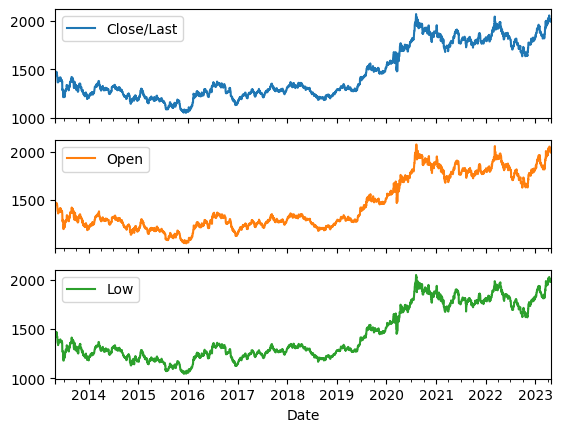

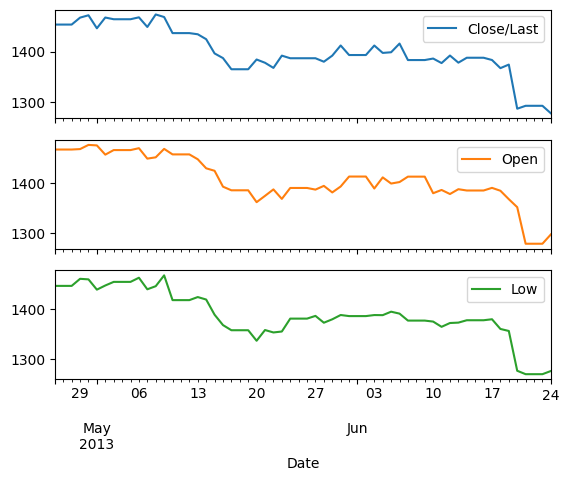

In [16]:
date_time = pd.to_datetime(data.pop('Date'), format='%Y-%m-%d')
plot_cols = ['Close/Last', 'Open', 'Low']
plot_features = data[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = data[plot_cols][:60]
plot_features.index = date_time[:60]
_ = plot_features.plot(subplots=True)

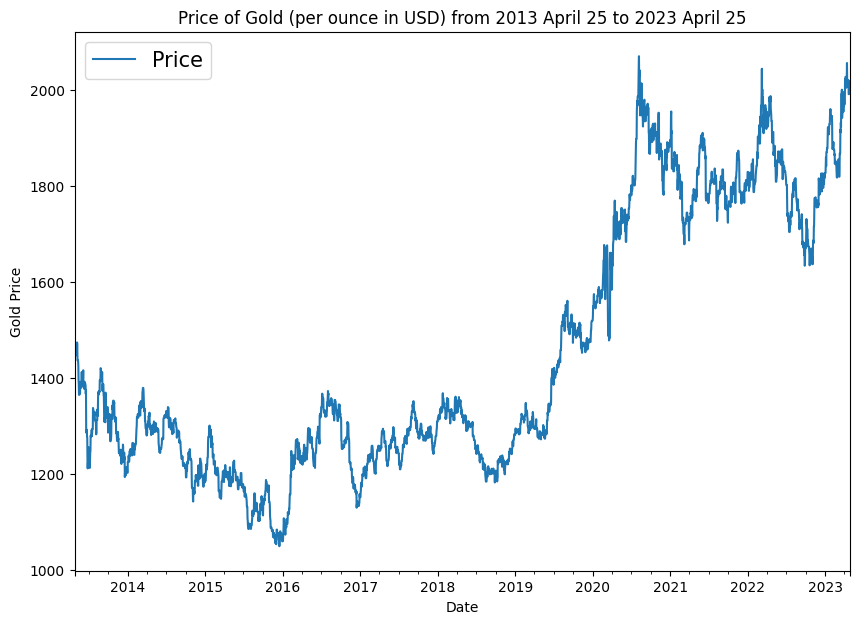

In [17]:
#plotting the data
gold_data.plot(figsize=(10, 7))
plt.ylabel("Gold Price")
plt.title("Price of Gold (per ounce in USD) from 2013 April 25 to 2023 April 25")
plt.legend(fontsize=15)

In [18]:
def plot_timeseries(timesteps, values, format=".", start=0, end=None, label=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Gold Price")
    if label:
        plt.legend(fontsize=12) # make label bigger
    plt.grid(True)

In [19]:
time = gold_data.index.to_numpy()
gold_price = gold_data.Price.to_numpy()

time[:5], gold_price[:5]

(array(['2013-04-26T00:00:00.000000000', '2013-04-27T00:00:00.000000000',
        '2013-04-28T00:00:00.000000000', '2013-04-29T00:00:00.000000000',
        '2013-04-30T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([1453.6, 1453.6, 1453.6, 1467.4, 1472.1]))

In [20]:
gold_price[-3645:].shape

(3645,)

In [21]:
hor = 1
win = 44

In [22]:
3645/45

81.0

In [23]:
gold_price_cut = gold_price[-3645:]

In [24]:
gold_price_cut.shape

(3645,)

In [25]:
#Creating the sliding window function that will help creating horizons and windows for the data
def making_windows_horizons(file, win=win, hor=hor):
    sliding_window = sliding_window_view(file, win+hor)
    return sliding_window[:, :-hor], sliding_window[:, -hor:]

In [26]:
full_windows, full_labels = making_windows_horizons(gold_price_cut, )

In [27]:
full_windows.shape, full_labels.shape

((3601, 44), (3601, 1))

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler  = MinMaxScaler() 
scaler.fit(full_windows)

full_wind = scaler.transform(full_windows)


In [29]:
scaler.fit(full_labels)
full_label = scaler.transform(full_labels)

In [30]:
maximum = np.max(full_wind)
min = np.min(full_wind)
maximum, min 

(1.0, 0.0)

In [31]:
max_l = np.max(full_label)
min_l = np.min(full_label)
max_l, min_l

(1.0, 0.0)

In [32]:
split_size = int(len(full_wind) * 0.9)
x_win = full_wind[:split_size]
x_lab = full_label[:split_size]
y_win = full_wind[split_size:]
y_lab = full_label[split_size:]

x_win.shape, x_lab.shape, y_win.shape, y_lab.shape

((3240, 44), (3240, 1), (361, 44), (361, 1))

In [33]:
maxim = np.max(x_win)
minim = np.min(x_win)
maxim, minim 

(1.0, 0.0)

In [34]:
x_win[:2]

array([[0.4065503 , 0.4065503 , 0.4065503 , 0.41027652, 0.3914493 ,
        0.41586586, 0.41086488, 0.37948617, 0.37948617, 0.37948617,
        0.37723083, 0.3676211 , 0.33987056, 0.33075113, 0.30898215,
        0.30898215, 0.30898215, 0.32800549, 0.32163169, 0.31162973,
        0.33555599, 0.33045695, 0.33045695, 0.33045695, 0.33045695,
        0.32369092, 0.33555599, 0.3553638 , 0.33673269, 0.33673269,
        0.33673269, 0.35526574, 0.34085115, 0.34212591, 0.35909002,
        0.32692685, 0.32692685, 0.32692685, 0.3298686 , 0.32104334,
        0.33575211, 0.32182781, 0.33143754, 0.33143754],
       [0.4065503 , 0.4065503 , 0.41027652, 0.3914493 , 0.41586586,
        0.41086488, 0.37948617, 0.37948617, 0.37948617, 0.37723083,
        0.3676211 , 0.33987056, 0.33075113, 0.30898215, 0.30898215,
        0.30898215, 0.32800549, 0.32163169, 0.31162973, 0.33555599,
        0.33045695, 0.33045695, 0.33045695, 0.33045695, 0.32369092,
        0.33555599, 0.3553638 , 0.33673269, 0.33673269, 0.3

In [35]:
# x_win = np.array(x_win, dtype=np.float32)
# x_lab = np.array(x_lab, dtype=np.float32)
# y_win = np.array(y_win, dtype=np.float32)
# y_lab = np.array(y_lab, dtype=np.float32)

In [36]:
#  Callbacks

def mc(model):
  path = os.path.join("models/", model)
  return tf.keras.callbacks.ModelCheckpoint(filepath=path,
                                              verbose=0,
                                              monitor="val_loss",
                                              save_best_only = True)

es = EarlyStopping(patience=20, monitor="val_loss")

reducerl = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=20,verbose=0,mode='auto')

## Downloading test data for all the models to make predictions 

In [37]:
test_data ,_ = get_the_latest_csv()

In [38]:
gold_test_price = test_data.Price.to_numpy()

In [39]:
gold_test_price.shape

(3645,)

In [40]:
test_full_wind_original, test_full_labels_original = making_windows_horizons(gold_test_price, win=win, hor=hor)

In [41]:
test_full_wind_original[:5], test_full_labels_original[:5], test_full_wind_original.shape, test_full_labels_original.shape

(array([[1395.8, 1393.1, 1420.2, 1418.8, 1412.9, 1396.1, 1396.1, 1396.1,
         1396.1, 1412. , 1390. , 1373. , 1386.5, 1386.5, 1386.5, 1386.7,
         1364. , 1363.8, 1330.6, 1308.6, 1308.6, 1308.6, 1317.8, 1309.4,
         1307.6, 1369.3, 1332.5, 1332.5, 1332.5, 1327. , 1316.3, 1336.2,
         1324.1, 1339.2, 1339.2, 1339.2, 1327. , 1286.1, 1320.7, 1317.6,
         1309.9, 1309.9, 1309.9, 1325.1],
        [1393.1, 1420.2, 1418.8, 1412.9, 1396.1, 1396.1, 1396.1, 1396.1,
         1412. , 1390. , 1373. , 1386.5, 1386.5, 1386.5, 1386.7, 1364. ,
         1363.8, 1330.6, 1308.6, 1308.6, 1308.6, 1317.8, 1309.4, 1307.6,
         1369.3, 1332.5, 1332.5, 1332.5, 1327. , 1316.3, 1336.2, 1324.1,
         1339.2, 1339.2, 1339.2, 1327. , 1286.1, 1320.7, 1317.6, 1309.9,
         1309.9, 1309.9, 1325.1, 1324.6],
        [1420.2, 1418.8, 1412.9, 1396.1, 1396.1, 1396.1, 1396.1, 1412. ,
         1390. , 1373. , 1386.5, 1386.5, 1386.5, 1386.7, 1364. , 1363.8,
         1330.6, 1308.6, 1308.6, 1308.6,

In [42]:
# Normalizing the test data
test_full_windows = scaler.fit_transform(test_full_wind_original)
test_full_labels = scaler.fit_transform(test_full_labels_original)

In [43]:
#The original test data
test_full_wind_o = test_full_wind_original[-3240:]

In [44]:
# Cuttin the size of the trainign data so its gonna match the training data 
test_full_w = test_full_windows[-3240:]
test_full_l = test_full_labels[-3240:]

In [45]:
test_full_w[:1], test_full_w.shape, test_full_l[:1], test_full_l.shape

(array([[0.22141596, 0.22612277, 0.22612277, 0.22612277, 0.22484801,
         0.23102569, 0.22926064, 0.23612473, 0.23318298, 0.23318298,
         0.23318298, 0.23318298, 0.21121789, 0.21641498, 0.21268876,
         0.21347323, 0.21347323, 0.21347323, 0.20072563, 0.19503824,
         0.19190037, 0.18572269, 0.17836831, 0.17836831, 0.17836831,
         0.18189841, 0.18346735, 0.18268288, 0.17385762, 0.1637576 ,
         0.1637576 , 0.1637576 , 0.16503236, 0.16905276, 0.16660129,
         0.1689547 , 0.1625809 , 0.1625809 , 0.1625809 , 0.16591489,
         0.15885468, 0.16267896, 0.16228672, 0.14051775]]),
 (3240, 44),
 array([[0.14051775]]),
 (3240, 1))

In [46]:
test_full_labels_o = test_full_labels_original[-3240:]
test_full_labels_o[-5:], test_full_labels_o.shape

(array([[1946.6],
        [1944. ],
        [1935.2],
        [1928.3],
        [1915.2]]),
 (3240, 1))

# Model0 Dense / Window: 43, Horizon: 1

In [47]:
# Model0: Dense
def model0(window_size, horizon):
    model = Sequential(name="model0_dense")
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1, activation="linear"))
    return model

In [48]:
model0 = model0(window_size=win, horizon=hor)

In [49]:
model0.name

'model0_dense'

In [50]:
x_win.shape, x_lab.shape, test_full_w.shape, test_full_labels.shape 

((3240, 44), (3240, 1), (3240, 44), (3601, 1))

In [51]:
model0.compile(loss = "mae", 
              optimizer = Adam(),
              metrics = ["mae", Precision(), Recall()])

hist = model0.fit(x_win, x_lab, epochs= 100,
                 validation_data= (y_win, y_lab),
                 batch_size = 32,
                 callbacks = [es, reducerl])

Epoch 1/100
102/102 [==============================] - 2s 6ms/step - loss: 0.0322 - mae: 0.0322 - precision: 1.0000 - recall: 0.2451 - val_loss: 0.0315 - val_mae: 0.0315 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/100
102/102 [==============================] - 0s 2ms/step - loss: 0.0160 - mae: 0.0160 - precision: 1.0000 - recall: 0.2532 - val_loss: 0.0187 - val_mae: 0.0187 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/100
102/102 [==============================] - 0s 2ms/step - loss: 0.0157 - mae: 0.0157 - precision: 1.0000 - recall: 0.2529 - val_loss: 0.0215 - val_mae: 0.0215 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/100
102/102 [==============================] - 0s 2ms/step - loss: 0.0152 - mae: 0.0152 - precision: 1.0000 - recall: 0.2532 - val_loss: 0.0247 - val_mae: 0.0247 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 5/100
102/102 [==============================] - 0s 2ms/step - loss: 0.0148 - mae:

102/102 [==============================] - 0s 2ms/step - loss: 0.0140 - mae: 0.0140 - precision: 1.0000 - recall: 0.2532 - val_loss: 0.0144 - val_mae: 0.0144 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 7/100
102/102 [==============================] - 0s 2ms/step - loss: 0.0124 - mae: 0.0124 - precision: 1.0000 - recall: 0.2535 - val_loss: 0.0132 - val_mae: 0.0132 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 8/100
102/102 [==============================] - 0s 2ms/step - loss: 0.0116 - mae: 0.0116 - precision: 1.0000 - recall: 0.2535 - val_loss: 0.0141 - val_mae: 0.0141 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 9/100
102/102 [==============================] - 0s 2ms/step - loss: 0.0117 - mae: 0.0117 - precision: 1.0000 - recall: 0.2556 - val_loss: 0.0142 - val_mae: 0.0142 - val_precision: 1.0000 - val_recall: 1.0000 - lr: 0.0010
Epoch 10/100
102/102 [==============================] - 0s 2ms/step - loss: 0.0140 - mae: 0.0140 - p

In [52]:
# Prediction of Model00
prediction_model0_val = model0.predict(y_win)

12/12 [==============================] - 0s 1ms/step


In [53]:
pred_model0_val = scaler.inverse_transform(prediction_model0_val)

In [54]:
prediction_model0_test = model0.predict(test_full_w)

 50/102 [=============>................] - ETA: 0s

102/102 [==============================] - 0s 1ms/step


In [55]:
pred_model0_test = scaler.inverse_transform(prediction_model0_test)

In [56]:
pred_model0_test[-5:], pred_model0_test.shape, test_full_labels_original[-5:], test_full_labels_original.shape

(array([[1940.3685],
        [1941.9229],
        [1937.1647],
        [1933.0764],
        [1926.9916]], dtype=float32),
 (3240, 1),
 array([[1946.6],
        [1944. ],
        [1935.2],
        [1928.3],
        [1915.2]]),
 (3601, 1))

In [57]:
model0_r2_score_test = r2_score(y_true=test_full_labels_o, y_pred=pred_model0_test)
model0_r2_score_test
f"Model_0 R2 score  on the test data: {model0_r2_score_test:.1%}"


'Model_0 R2 score  on the test data: 99.8%'

In [58]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,train_df=None, val_df=None, test_df=None, label_columns=None, inputs=None, labels=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.inputs = inputs
    self.labels = labels

    # Work out the label column indices
    self.label_columns = label_columns
    # if label_columns is not None:
    #   self.label_columns_indices = {name: i for i, name in
    #                                 enumerate(label_columns)}
    # self.column_indices = {name: i for i, name in
    #                        enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


  def plot(self, inputs, labels, model=None, plot_col='Gold Price', max_subplots=3):
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

In [59]:
reversed_x_win = scaler.inverse_transform(x_win)
reversed_y_win = scaler.inverse_transform(y_win)

In [60]:
reversed_x_win[:1], reversed_y_win[:1]

(array([[1464.2, 1464.2, 1464.2, 1468. , 1448.8, 1473.7, 1468.6, 1436.6,
         1436.6, 1436.6, 1434.3, 1424.5, 1396.2, 1386.9, 1364.7, 1364.7,
         1364.7, 1384.1, 1377.6, 1367.4, 1391.8, 1386.6, 1386.6, 1386.6,
         1386.6, 1379.7, 1391.8, 1412. , 1393. , 1393. , 1393. , 1411.9,
         1397.2, 1398.5, 1415.8, 1383. , 1383. , 1383. , 1386. , 1377. ,
         1392. , 1377.8, 1387.6, 1387.6]]),
 array([[1948.2, 1933.9, 1933.9, 1933.9, 1934.8, 1926.7, 1942.6, 1967.7,
         1959.8, 1959.8, 1959.8, 1944.7, 1918. , 1939. , 1954. , 1923.7,
         1923.7, 1923.7, 1934. , 1927.5, 1923.1, 1937.8, 1945.6, 1945.6,
         1945.6, 1948.2, 1976.1, 1984.7, 1974.9, 1974.9, 1974.9, 1974.9,
         1986.4, 1959. , 1955.6, 1948.2, 1934.3, 1934.3, 1934.3, 1896. ,
         1904.1, 1888.7, 1891.3, 1911.7]]))

In [61]:
window_model0 = WindowGenerator(input_width=44, label_width=1,shift=1, label_columns=gold_data["Price"], train_df=reversed_x_win, test_df=reversed_y_win)
window_model0

Total window size: 45
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Label indices: [44]
Label column name(s): Date
2013-04-26    1453.6
2013-04-27    1453.6
2013-04-28    1453.6
2013-04-29    1467.4
2013-04-30    1472.1
               ...  
2023-04-21    1990.5
2023-04-22    1990.5
2023-04-23    1990.5
2023-04-24    1999.8
2023-04-25    2004.5
Name: Price, Length: 3652, dtype: float64

In [62]:
original_label_val = scaler.inverse_transform(y_lab)
original_label_val.shape

(361, 1)

In [63]:
model0_r2_val = r2_score(y_true=original_label_val, y_pred = pred_model0_val)
f"Model_0 r2 score on validation data: {model0_r2_val:.1%}"

'Model_0 r2 score on validation data: 97.4%'

In [64]:
# Checking the model's accuracy 
def naive_roc_auc_score(y_true, y_pred):
    
  num_same_sign = 0
  num_pairs = 0
  
  for a in range(len(y_true)):
    for b in range(len(y_true)):
      if y_true[a] > y_true[b]:
        num_pairs += 1
        if y_pred[a] > y_pred[b]:
          num_same_sign += 1
        elif y_pred[a] == y_pred[b]:
          num_same_sign += .5
        
  return num_same_sign / num_pairs

In [65]:
model0_accuracy_val = naive_roc_auc_score(y_true=original_label_val, y_pred=pred_model0_val)
f"Model_0 accuracy on validation data: {model0_accuracy_val:.1%}"

'Model_0 accuracy on validation data: 95.5%'

In [66]:
model0_accuracy_test = naive_roc_auc_score(y_true=test_full_labels_o, y_pred=pred_model0_test)
f"Model_0 accuracy on the test data: {model0_accuracy_test:.1%}"

'Model_0 accuracy on the test data: 98.2%'

In [67]:
y_win_or = scaler.inverse_transform(y_win)
y_win_or[:5]

array([[1948.2, 1933.9, 1933.9, 1933.9, 1934.8, 1926.7, 1942.6, 1967.7,
        1959.8, 1959.8, 1959.8, 1944.7, 1918. , 1939. , 1954. , 1923.7,
        1923.7, 1923.7, 1934. , 1927.5, 1923.1, 1937.8, 1945.6, 1945.6,
        1945.6, 1948.2, 1976.1, 1984.7, 1974.9, 1974.9, 1974.9, 1974.9,
        1986.4, 1959. , 1955.6, 1948.2, 1934.3, 1934.3, 1934.3, 1896. ,
        1904.1, 1888.7, 1891.3, 1911.7],
       [1933.9, 1933.9, 1933.9, 1934.8, 1926.7, 1942.6, 1967.7, 1959.8,
        1959.8, 1959.8, 1944.7, 1918. , 1939. , 1954. , 1923.7, 1923.7,
        1923.7, 1934. , 1927.5, 1923.1, 1937.8, 1945.6, 1945.6, 1945.6,
        1948.2, 1976.1, 1984.7, 1974.9, 1974.9, 1974.9, 1974.9, 1986.4,
        1959. , 1955.6, 1948.2, 1934.3, 1934.3, 1934.3, 1896. , 1904.1,
        1888.7, 1891.3, 1911.7, 1911.7],
       [1933.9, 1933.9, 1934.8, 1926.7, 1942.6, 1967.7, 1959.8, 1959.8,
        1959.8, 1944.7, 1918. , 1939. , 1954. , 1923.7, 1923.7, 1923.7,
        1934. , 1927.5, 1923.1, 1937.8, 1945.6, 1945.6

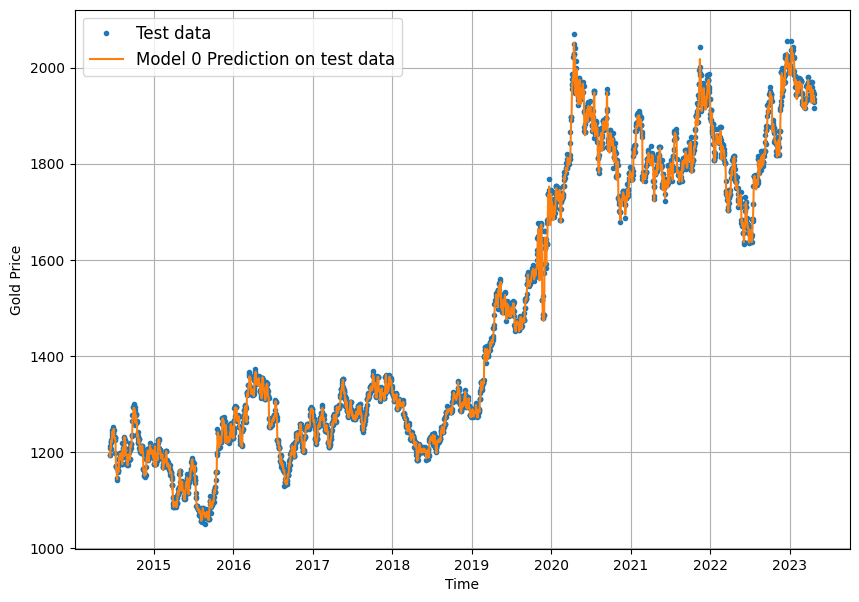

In [68]:
plt.figure(figsize=(10,7))
plot_timeseries(gold_data.index[-len(test_full_w):], test_full_labels_o[:,0], format=".", label="Test data")
plot_timeseries(gold_data.index[-len(test_full_w):], pred_model0_test[:,0], format="-", label="Model 0 Prediction on test data")

# Model1: Conv1D + LSTM / Window: 43, Horizon: 1

In [69]:
def model1(window_size, horizon):
    model = Sequential(name="model1_conv1d")
    model.add(Lambda(lambda x: tf.expand_dims(x, axis=1)))
    model.add(Conv1D(filters=128, kernel_size=2, input_shape=(window_size, 1), padding="causal", activation="relu"))
    model.add(MaxPooling1D(padding="same"))
    model.add(LSTM(128))
    model.add(Dense(hor, activation="linear")) 
    return model

In [70]:
model1 = model1(window_size=win, horizon=hor)

In [71]:
model1.compile(loss="mae",
                optimizer=Adam(),
                metrics = ["mae", Precision(), Recall()] )

In [72]:
hist1 = model1.fit(x_win,x_lab, epochs=100,
                    validation_data=(y_win, y_lab),
                    batch_size=32,
                    callbacks= [es, reducerl])

Epoch 1/100


102/102 [==============================] - 4s 9ms/step - loss: 0.0458 - mae: 0.0458 - precision_1: 1.0000 - recall_1: 0.2390 - val_loss: 0.0454 - val_mae: 0.0454 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - lr: 0.0010
Epoch 2/100
102/102 [==============================] - 0s 3ms/step - loss: 0.0192 - mae: 0.0192 - precision_1: 1.0000 - recall_1: 0.2535 - val_loss: 0.0220 - val_mae: 0.0220 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - lr: 0.0010
Epoch 3/100
102/102 [==============================] - 0s 3ms/step - loss: 0.0160 - mae: 0.0160 - precision_1: 1.0000 - recall_1: 0.2541 - val_loss: 0.0344 - val_mae: 0.0344 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - lr: 0.0010
Epoch 4/100
102/102 [==============================] - 0s 4ms/step - loss: 0.0156 - mae: 0.0156 - precision_1: 1.0000 - recall_1: 0.2563 - val_loss: 0.0173 - val_mae: 0.0173 - val_precision_1: 1.0000 - val_recall_1: 1.0000 - lr: 0.0010
Epoch 5/100
102/102 [==============================] - 1s 8ms/step -

In [73]:
prediction_model1_val = model1.predict(y_win)


12/12 [==============================] - 0s 1ms/step


In [74]:
prediction_model1_test = model1.predict(test_full_w)

  1/102 [..............................] - ETA: 2s

102/102 [==============================] - 0s 1ms/step


In [75]:
pred_model1_val = scaler.inverse_transform(prediction_model1_val)

In [76]:
pred_model1_test = scaler.inverse_transform(prediction_model1_test)

In [77]:
model1_r2_val = r2_score(y_true=original_label_val, y_pred=pred_model1_val)
f"Model_1 r2 score on validation data: {model1_r2_val:.1%}"

'Model_1 r2 score on validation data: 97.5%'

In [78]:
model1_r2_test = r2_score(y_true=test_full_labels_o, y_pred=pred_model1_test)
f"Model_1 r2 score on test data: {model1_r2_test:.1%}"

'Model_1 r2 score on test data: 99.8%'

In [79]:
model1_accuracy_val = naive_roc_auc_score(y_true=original_label_val, y_pred=pred_model1_val)
f"Model_1 accuracy on validation data: {model1_accuracy_val:.1%}"

'Model_1 accuracy on validation data: 95.4%'

In [80]:
model1_accuracy_test = naive_roc_auc_score(y_true=test_full_labels_o, y_pred=pred_model1_test)
f"Model_1 accuracy on test data: {model1_accuracy_test:.1%}"

'Model_1 accuracy on test data: 98.2%'

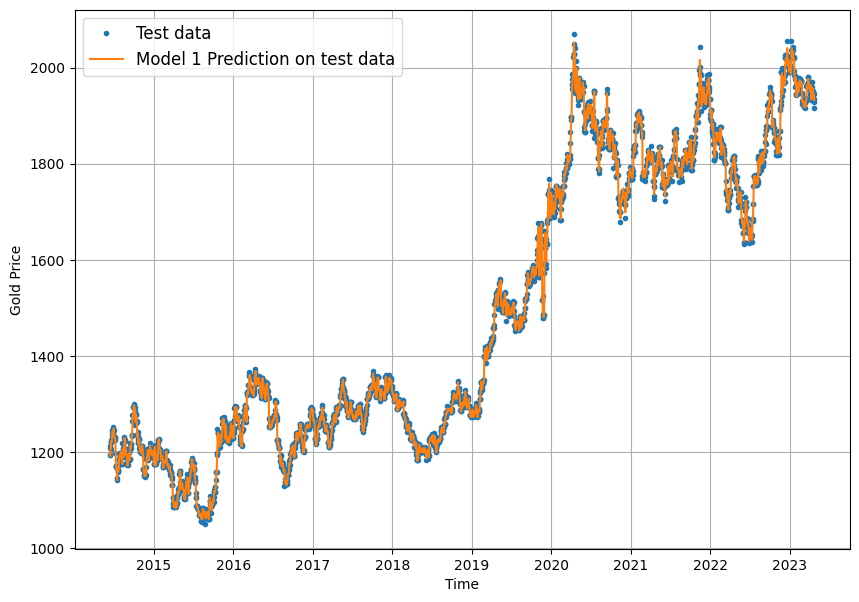

In [81]:
plt.figure(figsize=(10, 7))
plot_timeseries(gold_data.index[-len(test_full_w):], test_full_labels_o[:,0], format=".", label="Test data")
plot_timeseries(gold_data.index[-len(test_full_w):], pred_model1_test[:,0], format="-", label="Model 1 Prediction on test data")

### **Trying out darts models**

In [82]:
from darts.metrics import mae, mse
from darts.models import ExponentialSmoothing, TBATS, NBEATSModel, AutoARIMA, Theta
from darts import TimeSeries

In [83]:
gold_timeseries = TimeSeries.from_csv("Gold_data_reversed_filled.csv", value_cols=["Close/Last"])

In [84]:
gold_timeseries

<TimeSeries (DataArray) (time: 3652, component: 1, sample: 1)>
array([[[1453.6]],

       [[1453.6]],

       [[1453.6]],

       ...,

       [[1990.5]],

       [[1999.8]],

       [[2004.5]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 3645 3646 3647 3648 3649 3650 3651
  * component  (component) object 'Close/Last'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [85]:
split_size = int(len(gold_timeseries)* 0.8)

train = gold_timeseries[:split_size]
val = gold_timeseries[split_size:]

In [86]:
def models(model, train, val):
    model.fit(train)
    forecast = model.predict(len(val))
    print(f"Model: {model} obtaines MAE: {mae(val , forecast):.2f}%")
    

In [87]:
expo = models(ExponentialSmoothing(), train=train, val=val)

Model: ExponentialSmoothing() obtaines MAE: 177.65%


In [88]:
# nbeats = models(NBEATSModel(input_chunk_length=43, output_chunk_length=1, n_epochs=20),train=train, val=val)

In [89]:
tbats = models(TBATS(),train=train, val=val)

Model: TBATS() obtaines MAE: 72.96%


In [90]:
autoa = models(AutoARIMA(),train=train, val=val)

Model: AutoARIMA() obtaines MAE: 72.96%


In [91]:
theta = models(Theta(),train=train, val=val)

Model: Theta() obtaines MAE: 63.77%


# Model2: Dense /Window: 48, Horizon: 7

In [92]:
window = 38
horizon = 7


In [93]:
gold_price.shape, gold_test_price.shape

((3652,), (3645,))

In [94]:
#Creating training data 
full_windows_big , full_labels_big = making_windows_horizons(gold_price_cut, win=window, hor=horizon)
full_windows_big.shape, full_labels_big.shape

((3601, 38), (3601, 7))

In [95]:
# Creating test data
full_win_test7_or, full_lab7_or = making_windows_horizons(gold_test_price, win=window, hor=horizon)
full_win_test7_or.shape, full_lab7_or.shape

((3601, 38), (3601, 7))

In [96]:
full_lab7_or_scaled = full_lab7_or[-2880:]

In [97]:
#Normalizing the training data
scaler.fit(full_windows_big)
full_windows_big_scaled = scaler.transform(full_windows_big)

In [98]:
#Normalizing the labels
scaler.fit(full_labels_big)
full_labels_big_scaled = scaler.transform(full_labels_big)

In [99]:
#Normalizing the test data
full_test_win_scaled =  scaler.fit_transform(full_win_test7_or)
full_test_labels_scaled = scaler.fit_transform(full_lab7_or)

In [100]:
# getting the same shape for the test_data

full_test_win7 = full_test_win_scaled[-2880:]
full_test_lab7 = full_test_labels_scaled[-2880:]

In [101]:
split_size = int(len(full_labels_big) * 0.8)

x_win_b = full_windows_big_scaled[:split_size]
x_lab_b = full_labels_big_scaled[:split_size]
y_win_b = full_windows_big_scaled[split_size:]
y_lab_b = full_labels_big_scaled[split_size:]

In [102]:
x_win_b.shape, x_lab_b.shape, y_win_b.shape, y_lab_b.shape

((2880, 38), (2880, 7), (721, 38), (721, 7))

In [103]:
y_lab[:5], y_lab_b[:5]

(array([[0.84536184],
        [0.84536184],
        [0.79819572],
        [0.80505982],
        [0.80329476]]),
 array([[0.70474603, 0.70415768, 0.70415768, 0.70415768, 0.72778976,
         0.71229653, 0.72043538],
        [0.70415768, 0.70415768, 0.70415768, 0.72778976, 0.71229653,
         0.72043538, 0.75122573],
        [0.70415768, 0.70415768, 0.72778976, 0.71229653, 0.72043538,
         0.75122573, 0.76652285],
        [0.70415768, 0.72778976, 0.71229653, 0.72043538, 0.75122573,
         0.76652285, 0.76652285],
        [0.72778976, 0.71229653, 0.72043538, 0.75122573, 0.76652285,
         0.76652285, 0.76652285]]))

In [104]:
def model2(window, horizon):
    model = Sequential(name="model2_dense")
    model.add(Dense(256, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation ="relu"))
    model.add(Dense(horizon, activation="linear"))
    return model

In [105]:
model2 = model2(window=window, horizon=horizon)

In [106]:
model2.compile(loss="mae",
                optimizer=Adam(),
                metrics = ["mae", Precision()])

In [107]:
hist2 = model2.fit(x_win_b, x_lab_b, epochs=50,
                    validation_data=(y_win_b, y_lab_b),
                    callbacks=[es, reducerl], batch_size=64)

Epoch 1/50
29/45 [==================>...........] - ETA: 0s - loss: 0.0828 - mae: 0.0828 - precision_2: 1.0000      

45/45 [==============================] - 2s 9ms/step - loss: 0.0630 - mae: 0.0630 - precision_2: 1.0000 - val_loss: 0.0333 - val_mae: 0.0333 - val_precision_2: 1.0000 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0229 - mae: 0.0229 - precision_2: 1.0000 - val_loss: 0.0319 - val_mae: 0.0319 - val_precision_2: 1.0000 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0203 - mae: 0.0203 - precision_2: 1.0000 - val_loss: 0.0265 - val_mae: 0.0265 - val_precision_2: 1.0000 - lr: 0.0010
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0201 - mae: 0.0201 - precision_2: 1.0000 - val_loss: 0.0455 - val_mae: 0.0455 - val_precision_2: 1.0000 - lr: 0.0010
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 0.0201 - mae: 0.0201 - precision_2: 1.0000 - val_loss: 0.0245 - val_mae: 0.0245 - val_precision_2: 1.0000 - lr: 0.0010
Epoch 6/50
45/45 [==============================] - 0s 4

In [108]:
prediction_model2_val = model2.predict(y_win_b)

23/23 [==============================] - 0s 1ms/step


In [109]:
prediction_model2_test = model2.predict(full_test_win7)

 1/90 [..............................] - ETA: 1s

90/90 [==============================] - 0s 1ms/step


In [110]:
full_test_win7.shape, x_win_b.shape

((2880, 38), (2880, 38))

In [111]:
pred_model2_val = scaler.inverse_transform(prediction_model2_val)
pred_model2_test = scaler.inverse_transform(prediction_model2_test)

In [112]:
val_label_big7 = scaler.inverse_transform(y_lab_b)

In [113]:
val_label_big7.shape, pred_model2_val.shape

((721, 7), (721, 7))

In [114]:
val_label_big7[:,0].shape

(721,)

In [115]:
model2_r2_val = r2_score(y_true=val_label_big7[:,0], y_pred=pred_model2_val[:,0])
f"Model_2 r2 score on validation data: {model2_r2_val:.1%}"

'Model_2 r2 score on validation data: 96.3%'

In [116]:
model2_r2_test = r2_score(y_true=full_lab7_or_scaled[:,0], y_pred=pred_model2_test[:,0])
f"Model_2 r2 score on test data: {model2_r2_test:.1%}"

'Model_2 r2 score on test data: 99.8%'

In [117]:
model2_accuracy_val = naive_roc_auc_score(y_true=val_label_big7[:,0], y_pred=pred_model2_val[:,0])
f"Model_2 accuracy on validation data: {model2_accuracy_val:.1%}"

'Model_2 accuracy on validation data: 94.1%'

In [118]:
model2_accuracy_test = naive_roc_auc_score(y_true=full_lab7_or_scaled[:,0], y_pred=pred_model2_test[:,0])
f"Model_2 accuracy on test data: {model2_accuracy_test:.1%}"

'Model_2 accuracy on test data: 98.1%'

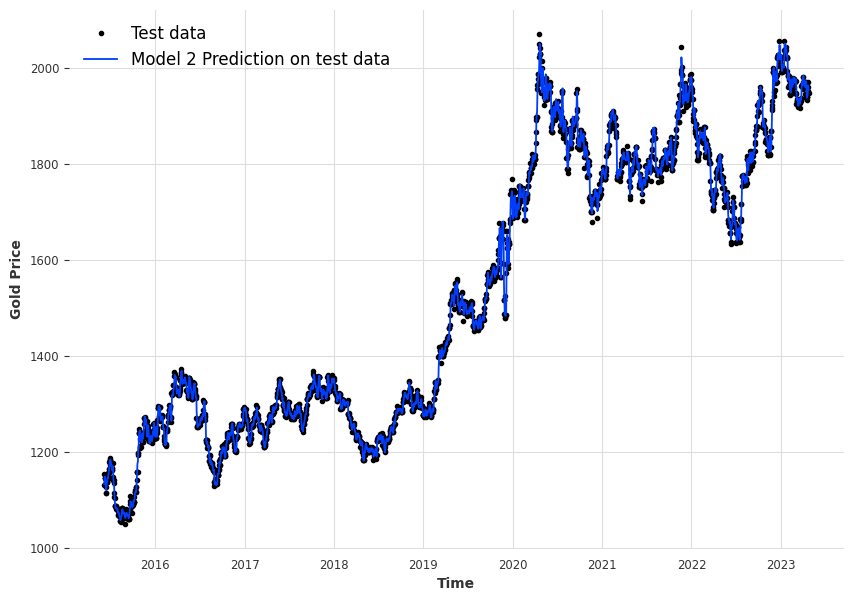

In [119]:
plt.figure(figsize=(10, 7))
plot_timeseries(gold_data.index[-len(full_test_win7):], full_lab7_or_scaled[:,0], format=".", label="Test data")
plot_timeseries(gold_data.index[-len(full_test_win7):], pred_model2_test[:,0], format="-", label="Model 2 Prediction on test data")

# Model3: Conv1D + LSTM / Window: 48, Horizon: 7

In [120]:
def model3(window):
    model = Sequential(name="model3_conv1d")
    model.add(Lambda(lambda x: tf.expand_dims(x, axis=1)))
    model.add(Conv1D(filters=128, kernel_size=2, input_shape=(window, 1), padding="causal", activation="relu"))
    model.add(MaxPooling1D(padding="same"))
    model.add(LSTM(128))
    model.add(Dense(horizon, activation="linear")) 
    return model

In [121]:
model3 = model3(window=window)

In [122]:
model3.compile(loss="mae",
                optimizer=Adam(),
                metrics = ["mae", Precision()])

In [123]:

hist3 = model3.fit(x_win_b,x_lab_b, epochs=50,
                    validation_data=(y_win_b, y_lab_b),
                    callbacks=[es, reducerl], batch_size=64)

Epoch 1/50


45/45 [==============================] - 5s 38ms/step - loss: 0.0808 - mae: 0.0808 - precision_3: 1.0000 - val_loss: 0.0464 - val_mae: 0.0464 - val_precision_3: 1.0000 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - 0s 9ms/step - loss: 0.0268 - mae: 0.0268 - precision_3: 1.0000 - val_loss: 0.0341 - val_mae: 0.0341 - val_precision_3: 1.0000 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0230 - mae: 0.0230 - precision_3: 1.0000 - val_loss: 0.0313 - val_mae: 0.0313 - val_precision_3: 1.0000 - lr: 0.0010
Epoch 4/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0210 - mae: 0.0210 - precision_3: 1.0000 - val_loss: 0.0283 - val_mae: 0.0283 - val_precision_3: 1.0000 - lr: 0.0010
Epoch 5/50
45/45 [==============================] - 0s 8ms/step - loss: 0.0200 - mae: 0.0200 - precision_3: 1.0000 - val_loss: 0.0272 - val_mae: 0.0272 - val_precision_3: 1.0000 - lr: 0.0010
Epoch 6/50
45/45 [==============================] - 0s 

In [124]:
prediction_model3_val = model3.predict(y_win_b)
prediction_model3_val[:2]

23/23 [==============================] - 0s 2ms/step


array([[0.71701574, 0.7219371 , 0.716638  , 0.71619934, 0.7169348 ,
        0.7166851 , 0.7156061 ],
       [0.7117187 , 0.7170474 , 0.71189296, 0.7124341 , 0.7128149 ,
        0.71436095, 0.712446  ]], dtype=float32)

In [125]:
prediction_model3_test = model3.predict(full_test_win7)

 1/90 [..............................] - ETA: 1s

90/90 [==============================] - 0s 2ms/step


In [126]:
pred_model3_val = scaler.inverse_transform(prediction_model3_val)

In [127]:
pred_model3_val.shape, pred_model3_val[-2:]

((721, 7),
 array([[2004.9934, 2013.4165, 2001.8342, 1999.3938, 1999.4839, 1999.633 ,
         1997.056 ],
        [2012.1443, 2018.5637, 2004.1979, 2003.    , 2004.1942, 2003.5867,
         1999.8007]], dtype=float32))

In [128]:
pred_model3_test = scaler.inverse_transform(prediction_model3_test)

In [129]:
model3_r2_val = r2_score(y_true=val_label_big7[:,0], y_pred=pred_model3_val[:,0])
f"Model_3 r2 score on validation data: {model3_r2_val:.1%}"

'Model_3 r2 score on validation data: 95.9%'

In [130]:
model3_r2_test = r2_score(y_true=full_lab7_or_scaled[:,0], y_pred=pred_model3_test[:,0])
f"Model_3 r2 score on test data: {model3_r2_test:.1%}"

'Model_3 r2 score on test data: 99.8%'

In [131]:
model3_accuracy_val = naive_roc_auc_score(y_true=val_label_big7[:,0], y_pred=pred_model3_val[:,0])
f"Model_3 accuracy on validation data: {model3_accuracy_val:.1%}"

'Model_3 accuracy on validation data: 93.9%'

In [132]:
model3_accuracy_test = naive_roc_auc_score(y_true=full_lab7_or_scaled[:,0], y_pred=pred_model3_test[:,0])
f"Model_3 accuracy on test data: {model3_accuracy_test:.1%}"

'Model_3 accuracy on test data: 98.0%'

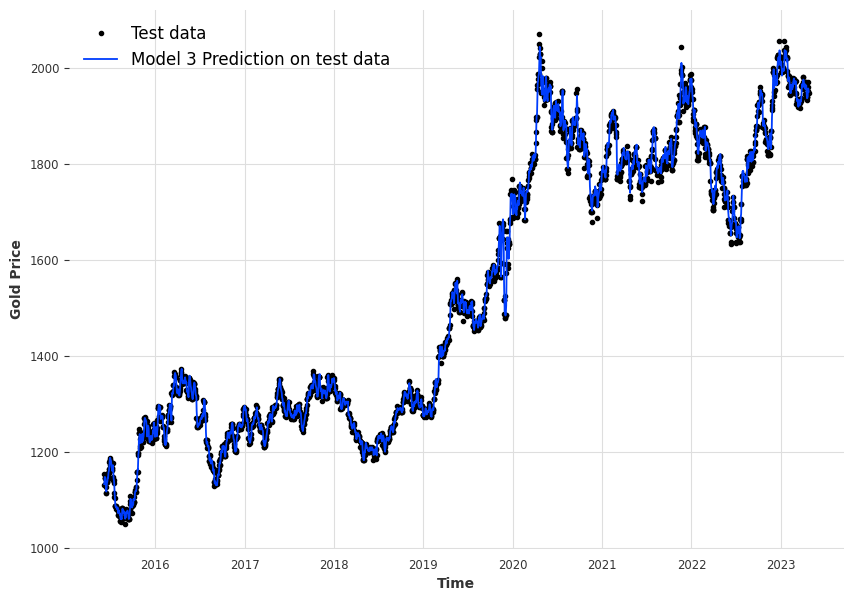

In [133]:
plt.figure(figsize=(10, 7))
plot_timeseries(gold_data.index[-len(full_test_win7):], full_lab7_or_scaled[:,0], format=".", label="Test data")
plot_timeseries(gold_data.index[-len(full_test_win7):], pred_model3_test[:,0], format="-", label="Model 3 Prediction on test data")

In [134]:
all_acc = pd.DataFrame({
                    'Model0_val': model0_accuracy_val,
                    'Model1_val': model1_accuracy_val,
                    'Model2_val': model2_accuracy_val,
                    "Model3_val": model3_accuracy_val,
                    'Model0_test': model0_accuracy_test,
                    'Model1_test': model1_accuracy_test,
                    'Model2_test': model2_accuracy_test,
                    "Model3_test": model3_accuracy_test},index=[0])


In [135]:
model0.save("Gold_model0.h5")
model1.save("Gold_model1.h5")
model2.save("Gold_model2.h5")
model3.save("Gold_model3.h5")

C:\Users\stadl\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3078: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


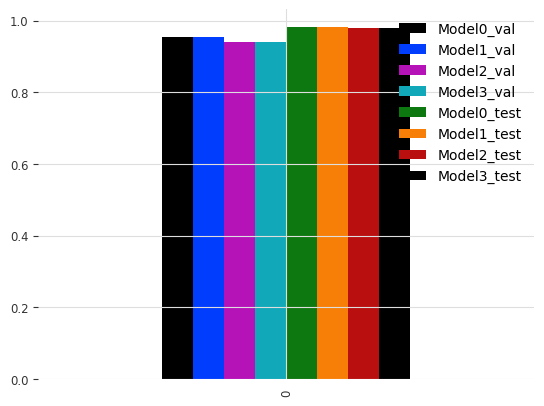

In [136]:
# Checking all the models accuracy
d = all_acc.plot(kind="bar")


# Where models takes all the historical data and predict the future values for a day (using only price as a feature)

In [137]:
#Creating other models that take all the historical data and predict a future data for one day 7 days
# One with all the data (date and price)
# Another with only the price

#  Creating train data

x_train_goldall = gold_data.iloc[-3646:-1]

y_train_goldall = gold_data.iloc[-1]



In [138]:
gold_data.shape

(3652, 1)

In [139]:
x_train_goldall.tail(8)


,Price
Date,
2023-04-17,2007.0
2023-04-18,2019.7
2023-04-19,2007.3
2023-04-20,2019.1
2023-04-21,1990.5
2023-04-22,1990.5
2023-04-23,1990.5
2023-04-24,1999.8


In [140]:
x_train_goldall.shape, y_train_goldall.shape 

((3645, 1), (1,))

In [141]:
y_train_goldall

Price    2004.5
Name: 2023-04-25 00:00:00, dtype: float64

In [142]:
y_train_goldall, y_train_goldall.shape

(Price    2004.5
 Name: 2023-04-25 00:00:00, dtype: float64,
 (1,))

In [143]:
minmax = MinMaxScaler()
x_train_goldall = minmax.fit_transform(x_train_goldall)

In [144]:
x_train_goldall[:5], len(x_train_goldall), x_train_goldall.shape

(array([[0.40988429],
        [0.4065503 ],
        [0.4065503 ],
        [0.4065503 ],
        [0.41027652]]),
 3645,
 (3645, 1))

In [145]:
x_train_goldall = x_train_goldall.reshape(1, -1)
x_train_goldall.shape

(1, 3645)

In [146]:
np.min(x_train_goldall), np.max(x_train_goldall)

(0.0, 1.0)

In [147]:
# Creating validation data from one of the downloaded files

def train_test_val_data1(path):
    data = pd.read_csv(path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.reindex(pd.date_range(data.index.min(), data.index.max())).sort_index(ascending=True).reset_index().rename(columns={'index': 'Date'})
    data = data.fillna(method="ffill")
    # data is the original pandas dataframe
    g_data = data[['Date','Close/Last']].copy()
    g_data = g_data.rename(columns={"Close/Last": "Price"})
    g_data = g_data.set_index("Date")
    x_test_org = g_data.iloc[-3646:-1]
    # print(x_test)
    y_test = g_data.iloc[-1]
    # x_test without normalization
    scaler = MinMaxScaler()
    x_test_normalized = scaler.fit_transform(x_test_org)
    # x_val with normalization
    x_test_normalized = x_test_normalized.reshape(1, -1)
    return x_test_normalized, y_test, x_test_org, data
    

In [148]:
file = "forecasting_csv\HistoricalData_1685021900505.csv"

x_val1, y_val1,_ ,_ = train_test_val_data1(file)

In [149]:
x_val1, x_val1.shape

(array([[0.33673269, 0.33673269, 0.33673269, ..., 0.91390469, 0.90959012,
         0.90694254]]),
 (1, 3645))

In [150]:
x_test1, y_test1, _, _ = train_test_val_data1("forecasting_csv\HistoricalData_1689601457702.csv")

In [151]:
x_test1[:10]

array([[0.23965483, 0.28211414, 0.28005491, ..., 0.87026868, 0.89439106,
        0.89645028]])

## Model4 Predict gold price for 1 day (Dense with all the historical data)

In [152]:

model4 = Sequential([
    Input(shape=(x_train_goldall[0].shape)),
    Dense(256, activation="relu"),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(1, activation = "linear"),
    
], name="model4_dense")

In [153]:
model4.summary()

Model: "model4_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               933376    
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 974593 (3.72 MB)
Trainable params: 974593 (3.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [154]:
model4.compile(loss="mae",
                optimizer = Adam(),
                metrics = ["mae", Precision()])

In [155]:
es = EarlyStopping(patience=30, monitor="mae")

In [156]:
hist4 = model4.fit(x_train_goldall,y_train_goldall,validation_data=(x_val1, y_val1),
                    epochs = 80, callbacks= [es, reducerl], batch_size=64)

Epoch 1/80
1/1 [==============================] - 1s 1s/step - loss: 2005.1637 - mae: 2005.1637 - precision_4: 0.0000e+00 - val_loss: 1965.0592 - val_mae: 1965.0592 - val_precision_4: 0.0000e+00 - lr: 0.0010
Epoch 2/80
1/1 [==============================] - 0s 48ms/step - loss: 2004.9377 - mae: 2004.9377 - precision_4: 0.0000e+00 - val_loss: 1963.4822 - val_mae: 1963.4822 - val_precision_4: 1.0000 - lr: 0.0010
Epoch 3/80
1/1 [==============================] - 0s 58ms/step - loss: 2003.3817 - mae: 2003.3817 - precision_4: 1.0000 - val_loss: 1962.0568 - val_mae: 1962.0568 - val_precision_4: 1.0000 - lr: 0.0010
Epoch 4/80
1/1 [==============================] - 0s 52ms/step - loss: 2001.9915 - mae: 2001.9915 - precision_4: 1.0000 - val_loss: 1960.3789 - val_mae: 1960.3789 - val_precision_4: 1.0000 - lr: 0.0010
Epoch 5/80
1/1 [==============================] - 0s 44ms/step - loss: 2000.3374 - mae: 2000.3374 - precision_4: 1.0000 - val_loss: 1958.4917 - val_mae: 1958.4917 - val_precision_4: 

1/1 [==============================] - 0s 48ms/step - loss: 1968.8622 - mae: 1968.8622 - precision_4: 1.0000 - val_loss: 1922.1727 - val_mae: 1922.1727 - val_precision_4: 1.0000 - lr: 0.0010
Epoch 15/80
1/1 [==============================] - 0s 53ms/step - loss: 1962.5796 - mae: 1962.5796 - precision_4: 1.0000 - val_loss: 1915.0068 - val_mae: 1915.0068 - val_precision_4: 1.0000 - lr: 0.0010
Epoch 16/80
1/1 [==============================] - 0s 51ms/step - loss: 1955.4989 - mae: 1955.4989 - precision_4: 1.0000 - val_loss: 1906.9913 - val_mae: 1906.9913 - val_precision_4: 1.0000 - lr: 0.0010
Epoch 17/80
1/1 [==============================] - 0s 95ms/step - loss: 1947.5782 - mae: 1947.5782 - precision_4: 1.0000 - val_loss: 1898.0930 - val_mae: 1898.0930 - val_precision_4: 1.0000 - lr: 0.0010
Epoch 18/80
1/1 [==============================] - 0s 47ms/step - loss: 1938.7839 - mae: 1938.7839 - precision_4: 1.0000 - val_loss: 1888.2126 - val_mae: 1888.2126 - val_precision_4: 1.0000 - lr: 0.00

In [157]:
prediction_model4_test = model4.predict(x_test1)

1/1 [==============================] - 0s 62ms/step


In [158]:
prediction_model4_test, y_test1

(array([[2008.6321]], dtype=float32),
 Price    1964.4
 Name: 2023-07-14 00:00:00, dtype: float64)

## Model5 Predict gold price for 1 day (Conv1D model with all the historical data)

In [159]:
#Conv1D model 
model5 = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=1)),
    Conv1D(filters= 256, kernel_size = 2, input_shape=(x_train_goldall[0].shape, 1), padding="causal", activation="relu"),
    MaxPooling1D(padding="same"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Flatten(),
    Dense(1, activation="linear")
], name="model5_conv1d")


In [160]:
model5.compile(loss="mae",
                optimizer=Adam(),
                metrics = ["mae", Precision()])

In [161]:
hist5 = model5.fit(x_train_goldall, y_train_goldall, epochs = 100, batch_size=64, validation_data=(x_val1, y_val1),
                    callbacks = [es, reducerl])

Epoch 1/100


1/1 [==============================] - 2s 2s/step - loss: 2004.4874 - mae: 2004.4874 - precision_5: 0.0000e+00 - val_loss: 1961.9255 - val_mae: 1961.9255 - val_precision_5: 1.0000 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 79ms/step - loss: 2001.8226 - mae: 2001.8226 - precision_5: 1.0000 - val_loss: 1958.8000 - val_mae: 1958.8000 - val_precision_5: 1.0000 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 65ms/step - loss: 1998.7400 - mae: 1998.7400 - precision_5: 1.0000 - val_loss: 1955.0137 - val_mae: 1955.0137 - val_precision_5: 1.0000 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 54ms/step - loss: 1994.9951 - mae: 1994.9951 - precision_5: 1.0000 - val_loss: 1950.6329 - val_mae: 1950.6329 - val_precision_5: 1.0000 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 57ms/step - loss: 1990.6791 - mae: 1990.6791 - precision_5: 1.0000 - val_loss: 1945.3752 - val_mae: 1945.3752 - val_precision_5: 1.0000 - lr: 0.

In [162]:
# Downloading testing data and making predictions on the models

def getting_testing_data(path):
    data = pd.read_csv(path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.reindex(pd.date_range(data.index.min(), data.index.max())).sort_index(ascending=True).reset_index().rename(columns={'index': 'Date'})
    data = data.fillna(method="ffill")
    g_data = data[['Date', "Close/Last"]].copy()
    # g_data = g_data.rename(columns={"Close/Last": "Price"})
    g_data = g_data.set_index("Date")
    x_data = g_data.iloc[:3645]
    # x_data is the data without normalization
    test_y = g_data.iloc[3646]
    x_data_test = scaler.fit_transform(x_data)
    test_x = x_data_test.reshape(1, -1)
    #test_x is the data with normalization
    return x_data, test_x, test_y, data

In [163]:
path = "forecasting_csv\HistoricalData_1687351319978.csv"

x_test_origin, x_test, y_test, test_data = getting_testing_data(path)

In [164]:
test_data

,Date,Close/Last,Volume,Open,High,Low
0,2013-06-21,1292.0,170210.0,1277.6,1301.7,1268.7
1,2013-06-22,1292.0,170210.0,1277.6,1301.7,1268.7
2,2013-06-23,1292.0,170210.0,1277.6,1301.7,1268.7
3,2013-06-24,1277.1,149366.0,1296.3,1300.7,1275.1
4,2013-06-25,1275.1,144701.0,1281.7,1289.0,1270.7
...,...,...,...,...,...,...
3647,2023-06-16,1971.2,157636.0,1970.3,1980.4,1965.4
3648,2023-06-17,1971.2,157636.0,1970.3,1980.4,1965.4
3649,2023-06-18,1971.2,157636.0,1970.3,1980.4,1965.4
3650,2023-06-19,1971.2,157636.0,1970.3,1980.4,1965.4


In [165]:
y_test

Close/Last    1970.7
Name: 2023-06-15 00:00:00, dtype: float64

In [166]:
x_test_origin

,Close/Last
Date,
2013-06-21,1292.0
2013-06-22,1292.0
2013-06-23,1292.0
2013-06-24,1277.1
2013-06-25,1275.1
...,...
2023-06-09,1977.2
2023-06-10,1977.2
2023-06-11,1977.2


In [167]:
model4.evaluate(x_train_goldall)
model5.evaluate(x_train_goldall)

1/1 [==============================] - 0s 139ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - precision_5: 0.0000e+00


[0.0, 0.0, 0.0]

In [168]:
model4_pred = model4.predict(x_test)
model5_pred = model5.predict(x_test)

1/1 [==============================] - 0s 143ms/step


In [169]:
model4_pred, model5_pred

(array([[1981.3937]], dtype=float32), array([[2062.1138]], dtype=float32))

## Model6 Predict for 7 days using all historical data (Dense model)

### Needed to reduce the training data more as sometimes in historical data there were not enough data for 3645 +7 rows 

In [170]:
def train_test_val_data7(path):
    data = pd.read_csv(path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.reindex(pd.date_range(data.index.min(), data.index.max())).sort_index(ascending=True).reset_index().rename(columns={'index': 'Date'})
    data = data.fillna(method="ffill")
    # data is the original pandas dataframe
    g_data = data[['Date','Close/Last']].copy()
    g_data = g_data.rename(columns={"Close/Last": "Price"})
    g_data = g_data.set_index("Date")
    x_data = g_data.iloc[-3607:-7]
    y_data = g_data.iloc[-7:]
    return x_data, y_data, g_data


In [171]:
x_train7, y_train7,_= train_test_val_data7("forecasting_csv\HistoricalData_1685019857920.csv")

In [172]:
data_scaler = MinMaxScaler()
data_scaler.fit(x_train7)
y_data_reduced = tf.squeeze(y_train7)
x_data_norm = data_scaler.fit_transform(x_train7)
y_data_norm = data_scaler.fit_transform(y_train7)
x_train7= x_data_norm.reshape(1, -1)
y_train7 = y_data_norm.reshape(1, -1)

In [173]:
x_train7[:5], x_train7.shape, y_train7, y_train7.shape

(array([[0.19248872, 0.1939596 , 0.22582859, ..., 0.95420671, 0.92508335,
         0.91714062]]),
 (1, 3600),
 array([[0.        , 1.        , 1.        , 1.        , 0.79816514,
         0.67431193, 0.22018349]]),
 (1, 7))

In [174]:
x_val7, y_val7, _, =train_test_val_data7("forecasting_csv\HistoricalData_1687357340623.csv")

In [175]:
y_val_reduced = tf.squeeze(y_val7)
x_val_norm = data_scaler.fit_transform(x_val7)
y_val_norm = data_scaler.fit_transform(y_val7)
x_val7= x_val_norm.reshape(1, -1)
y_val7 = y_val_norm.reshape(1, -1)

In [176]:
x_val7[:5], x_val7.shape, y_val7, y_val7.shape

(array([[0.24789174, 0.22837811, 0.23112375, ..., 0.90959012, 0.90223573,
         0.89135125]]),
 (1, 3600),
 array([[0.90212766, 0.9787234 , 1.        , 1.        , 1.        ,
         1.        , 0.        ]]),
 (1, 7))

In [177]:
x_test7, y_test7,_ = train_test_val_data7("forecasting_csv\HistoricalData_1689601457702.csv")

In [178]:
y_test_reduced_original = tf.squeeze(y_test7)
x_test_norm = data_scaler.fit_transform(x_test7)
y_test_norm = data_scaler.fit_transform(y_test7)
x_test7= x_test_norm.reshape(1, -1)
y_test7 = y_test_norm.reshape(1, -1)

In [179]:
x_test7[:5], x_test7.shape, y_test7, y_test7.shape

(array([[0.35624632, 0.3397725 , 0.3397725 , ..., 0.86046284, 0.84899   ,
         0.86575799]]),
 (1, 3600),
 array([[0.04491018, 0.04491018, 0.        , 0.18263473, 0.91916168,
         0.98203593, 1.        ]]),
 (1, 7))

In [180]:
# Model6: Dense
def model6():
    model = Sequential(name="model6_dense")
    model.add(Dense(128, activation="relu"))
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(7, activation="linear"))
    return model

In [181]:
model6 = model6()

In [182]:
model6.compile(loss="mae",
                optimizer=Adam(),
                metrics = ["mae", Precision(), Recall()] )

In [183]:
hist6 = model6.fit(x_train7, y_train7, epochs = 50, batch_size=32, validation_data=(x_val7, y_test7),
                    callbacks = [es, reducerl])

Epoch 1/50


1/1 [==============================] - 1s 1s/step - loss: 0.7905 - mae: 0.7905 - precision_6: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.5285 - val_mae: 0.5285 - val_precision_6: 1.0000 - val_recall_2: 0.1667 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 44ms/step - loss: 0.5553 - mae: 0.5553 - precision_6: 1.0000 - recall_2: 0.1667 - val_loss: 0.4346 - val_mae: 0.4346 - val_precision_6: 0.7500 - val_recall_2: 0.5000 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 44ms/step - loss: 0.3357 - mae: 0.3357 - precision_6: 1.0000 - recall_2: 0.6667 - val_loss: 0.6155 - val_mae: 0.6155 - val_precision_6: 0.7500 - val_recall_2: 0.5000 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 0s 48ms/step - loss: 0.3019 - mae: 0.3019 - precision_6: 1.0000 - recall_2: 0.6667 - val_loss: 0.7908 - val_mae: 0.7908 - val_precision_6: 0.8000 - val_recall_2: 0.6667 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 51ms/step - loss: 0.2505

In [184]:
model6.evaluate(x_val7)

1/1 [==============================] - 0s 230ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - precision_6: 0.0000e+00 - recall_2: 0.0000e+00


[0.0, 0.0, 0.0, 0.0]

In [185]:
prediction_model6_test = model6.predict(x_test7)

1/1 [==============================] - 0s 116ms/step


In [186]:
prediction_model6_test

array([[0.00759834, 1.0487963 , 0.9920036 , 0.9944852 , 0.83444816,
        0.67703646, 0.1630691 ]], dtype=float32)

In [187]:
pred_model6_test = data_scaler.inverse_transform(prediction_model6_test)

In [188]:
pred_model6_test, y_test_reduced_original

(array([[1931.2538, 1966.0298, 1964.1329, 1964.2158, 1958.8706, 1953.613 ,
         1936.4465]], dtype=float32),
 <tf.Tensor: shape=(7,), dtype=float64, numpy=array([1932.5, 1932.5, 1931. , 1937.1, 1961.7, 1963.8, 1964.4])>)

In [189]:
y_test_original = tf.squeeze(y_test_reduced_original)

In [190]:
y_test_original

<tf.Tensor: shape=(7,), dtype=float64, numpy=array([1932.5, 1932.5, 1931. , 1937.1, 1961.7, 1963.8, 1964.4])>

In [191]:
pred_model6_test = tf.convert_to_tensor(pred_model6_test)

In [192]:
pred_model6_test = tf.squeeze(pred_model6_test)

In [193]:
pred_model6_test

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([1931.2538, 1966.0298, 1964.1329, 1964.2158, 1958.8706, 1953.613 ,
       1936.4465], dtype=float32)>

In [194]:
model6_r2_test = r2_score(y_true=y_test_original, y_pred=pred_model6_test)
f"Model_6 r2 score on test data: {model6_r2_test:.1%}"

'Model_6 r2 score on test data: -145.3%'

In [195]:
model6_naive_test = naive_roc_auc_score(y_true=y_test_original, y_pred=pred_model6_test)
f"Model_6 navie roc curve score on test data: {model6_naive_test:.1%}"

'Model_6 navie roc curve score on test data: 30.0%'

## Model7 Predict for 7 days using all historical data (Conv1D model)

In [196]:
# Model7: Conv1D , LSTM
def model7():
    model = Sequential(name="model7_conv1d")
    model.add(Lambda(lambda x: tf.expand_dims(x, axis=1)))
    model.add(Conv1D(filters=128, kernel_size=2, input_shape=(x_train7[0].shape, 1), padding="causal", activation="relu"))
    model.add(MaxPooling1D(padding="same"))
    model.add(LSTM(128))
    model.add(Dense(7, activation="linear")) 
    return model

In [197]:
model7 = model7()

In [198]:
model7.compile(loss="mae",
                optimizer=Adam(),
                metrics = ["mae", Precision(), Recall()] )

In [199]:
hist7 = model7.fit(x_train7, y_train7, epochs = 50, batch_size=32, validation_data=(x_val7, y_test7),
                    callbacks = [es, reducerl])

Epoch 1/50


1/1 [==============================] - 6s 6s/step - loss: 0.6615 - mae: 0.6615 - precision_7: 0.0000e+00 - recall_3: 0.0000e+00 - val_loss: 0.4921 - val_mae: 0.4921 - val_precision_7: 1.0000 - val_recall_3: 0.1667 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 0s 80ms/step - loss: 0.5175 - mae: 0.5175 - precision_7: 1.0000 - recall_3: 0.1667 - val_loss: 0.5576 - val_mae: 0.5576 - val_precision_7: 0.7500 - val_recall_3: 0.5000 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 0s 81ms/step - loss: 0.2887 - mae: 0.2887 - precision_7: 1.0000 - recall_3: 0.5000 - val_loss: 0.5936 - val_mae: 0.5936 - val_precision_7: 0.8000 - val_recall_3: 0.6667 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 0s 93ms/step - loss: 0.1167 - mae: 0.1167 - precision_7: 1.0000 - recall_3: 0.8333 - val_loss: 0.6262 - val_mae: 0.6262 - val_precision_7: 0.8000 - val_recall_3: 0.6667 - lr: 0.0010
Epoch 5/50
1/1 [==============================] - 0s 80ms/step - loss: 0.1370

In [200]:
model7.summary()

Model: "model7_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 1, 3600)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 128)            921728    
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 1, 128)            0         
 g1D)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_21 (Dense)            (None, 7)                 903       
                                                                 
Total params: 1054215 (4.02 MB)
Trainable params: 1054215 (4.02 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [201]:
model7.evaluate(x_val7)

1/1 [==============================] - 1s 673ms/step - loss: 0.0000e+00 - mae: 0.0000e+00 - precision_7: 0.0000e+00 - recall_3: 0.0000e+00


[0.0, 0.0, 0.0, 0.0]

In [202]:
prediction_model7_test = model7.predict(x_test7)
prediction_model7_test

1/1 [==============================] - 1s 701ms/step


array([[-0.00324615,  0.98278695,  0.99953777,  0.9982649 ,  0.7994268 ,
         0.7141593 ,  0.22189656]], dtype=float32)

In [203]:
pred_model7_test = data_scaler.inverse_transform(prediction_model7_test)
pred_model7_test

array([[1930.8916, 1963.8251, 1964.3845, 1964.342 , 1957.7008, 1954.8529,
        1938.4113]], dtype=float32)

In [204]:
pred_model7_test.shape

(1, 7)

In [205]:
pred_model7_test = pred_model7_test.flatten()

In [206]:
pred_model7_test

array([1930.8916, 1963.8251, 1964.3845, 1964.342 , 1957.7008, 1954.8529,
       1938.4113], dtype=float32)

In [207]:
model7_r2_test = r2_score(y_true=y_test_original, y_pred=pred_model7_test)
f"Model_7 r2 score on test data: {model7_r2_test:.1%}"

'Model_7 r2 score on test data: -130.0%'

In [208]:
model7_naive_test = naive_roc_auc_score(y_true=y_test_original, y_pred=pred_model7_test)
f"Model_7 navie roc curve score on test data: {model7_naive_test:.1%}"

'Model_7 navie roc curve score on test data: 25.0%'

In [209]:
model4.save("model4.keras")

In [210]:
model4.save("saved_models/Gold_model4.keras")
model5.save("saved_models/Gold_model5.keras")
model6.save("saved_models/Gold_model6.keras")
model7.save("saved_models/Gold_model7.keras")

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/Gold_model4.keras'

## Model8 prophet

In [ ]:
from prophet import Prophet

In [ ]:
pro = Prophet()

In [ ]:
gold_data.tail()

,Price
Date,
2023-04-21,1990.5
2023-04-22,1990.5
2023-04-23,1990.5
2023-04-24,1999.8
2023-04-25,2004.5


In [ ]:
prophet_data = gold_data.copy()

In [ ]:
prophet_data = prophet_data.reset_index()

In [ ]:
prophet_data = prophet_data.rename(columns={"Date": "ds", "Price": "y"})
prophet_data.head()

,ds,y
0,2013-04-26,1453.6
1,2013-04-27,1453.6
2,2013-04-28,1453.6
3,2013-04-29,1467.4
4,2013-04-30,1472.1


In [ ]:
prophet_data.tail()

,ds,y
3647,2023-04-21,1990.5
3648,2023-04-22,1990.5
3649,2023-04-23,1990.5
3650,2023-04-24,1999.8
3651,2023-04-25,2004.5


In [ ]:
pro.fit(prophet_data)

13:10:27 - cmdstanpy - INFO - Chain [1] start processing


13:10:28 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
future_gold_data = pro.make_future_dataframe(periods=7)
future_gold_data.tail(8)

,ds
3651,2023-04-25
3652,2023-04-26
3653,2023-04-27
3654,2023-04-28
3655,2023-04-29
3656,2023-04-30
3657,2023-05-01
3658,2023-05-02


In [ ]:
gold_forecast = pro.predict(future_gold_data)

In [ ]:
gold_forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-04-26,1372.517134,1340.600480,1465.881684,1372.517134,1372.517134,31.905331,31.905331,31.905331,-0.043648,-0.043648,-0.043648,31.948980,31.948980,31.948980,0.0,0.0,0.0,1404.422465
1,2013-04-27,1372.166410,1344.572118,1461.589564,1372.166410,1372.166410,30.326444,30.326444,30.326444,-0.171791,-0.171791,-0.171791,30.498235,30.498235,30.498235,0.0,0.0,0.0,1402.492853
2,2013-04-28,1371.815686,1336.362142,1467.272576,1371.815686,1371.815686,28.769364,28.769364,28.769364,-0.303141,-0.303141,-0.303141,29.072505,29.072505,29.072505,0.0,0.0,0.0,1400.585050
3,2013-04-29,1371.464962,1342.617772,1464.367085,1371.464962,1371.464962,28.136896,28.136896,28.136896,0.448272,0.448272,0.448272,27.688624,27.688624,27.688624,0.0,0.0,0.0,1399.601858
4,2013-04-30,1371.114238,1337.846761,1457.977601,1371.114238,1371.114238,26.376771,26.376771,26.376771,0.015304,0.015304,0.015304,26.361467,26.361467,26.361467,0.0,0.0,0.0,1397.491009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654,2023-04-28,1854.298756,1826.911740,1947.757376,1854.298756,1854.298756,29.737500,29.737500,29.737500,-0.043648,-0.043648,-0.043648,29.781148,29.781148,29.781148,0.0,0.0,0.0,1884.036256
3655,2023-04-29,1854.392038,1824.974918,1945.271820,1854.392038,1854.392038,28.202564,28.202564,28.202564,-0.171791,-0.171791,-0.171791,28.374355,28.374355,28.374355,0.0,0.0,0.0,1882.594602
3656,2023-04-30,1854.485320,1823.240088,1938.834198,1854.485320,1854.485320,26.713966,26.713966,26.713966,-0.303141,-0.303141,-0.303141,27.017107,27.017107,27.017107,0.0,0.0,0.0,1881.199287
3657,2023-05-01,1854.578602,1818.369654,1941.074376,1854.578602,1854.578602,26.171493,26.171493,26.171493,0.448272,0.448272,0.448272,25.723221,25.723221,25.723221,0.0,0.0,0.0,1880.750095


In [ ]:
gold_forecast[["ds", 'yhat', 'yhat_lower', 'yhat_upper']].tail(8)

,ds,yhat,yhat_lower,yhat_upper
3651,2023-04-25,1888.165323,1831.544132,1948.003674
3652,2023-04-26,1886.463531,1827.077782,1949.479658
3653,2023-04-27,1885.808744,1819.785717,1948.216867
3654,2023-04-28,1884.036256,1826.911740,1947.757376
3655,2023-04-29,1882.594602,1824.974918,1945.271820
3656,2023-04-30,1881.199287,1823.240088,1938.834198
3657,2023-05-01,1880.750095,1818.369654,1941.074376
3658,2023-05-02,1879.191444,1817.228155,1941.320568


In [ ]:
gold_full = gold_forecast.copy()

In [ ]:
gold_full.insert(1, "Original_price", prophet_data["y"], True)

In [ ]:
prophet_data.tail(2)

,ds,y
3650,2023-04-24,1999.8
3651,2023-04-25,2004.5


In [ ]:
gold_full

,ds,Original_price,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-04-26,1453.6,1372.517134,1340.600480,1465.881684,1372.517134,1372.517134,31.905331,31.905331,31.905331,-0.043648,-0.043648,-0.043648,31.948980,31.948980,31.948980,0.0,0.0,0.0,1404.422465
1,2013-04-27,1453.6,1372.166410,1344.572118,1461.589564,1372.166410,1372.166410,30.326444,30.326444,30.326444,-0.171791,-0.171791,-0.171791,30.498235,30.498235,30.498235,0.0,0.0,0.0,1402.492853
2,2013-04-28,1453.6,1371.815686,1336.362142,1467.272576,1371.815686,1371.815686,28.769364,28.769364,28.769364,-0.303141,-0.303141,-0.303141,29.072505,29.072505,29.072505,0.0,0.0,0.0,1400.585050
3,2013-04-29,1467.4,1371.464962,1342.617772,1464.367085,1371.464962,1371.464962,28.136896,28.136896,28.136896,0.448272,0.448272,0.448272,27.688624,27.688624,27.688624,0.0,0.0,0.0,1399.601858
4,2013-04-30,1472.1,1371.114238,1337.846761,1457.977601,1371.114238,1371.114238,26.376771,26.376771,26.376771,0.015304,0.015304,0.015304,26.361467,26.361467,26.361467,0.0,0.0,0.0,1397.491009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654,2023-04-28,NaN,1854.298756,1826.911740,1947.757376,1854.298756,1854.298756,29.737500,29.737500,29.737500,-0.043648,-0.043648,-0.043648,29.781148,29.781148,29.781148,0.0,0.0,0.0,1884.036256
3655,2023-04-29,NaN,1854.392038,1824.974918,1945.271820,1854.392038,1854.392038,28.202564,28.202564,28.202564,-0.171791,-0.171791,-0.171791,28.374355,28.374355,28.374355,0.0,0.0,0.0,1882.594602
3656,2023-04-30,NaN,1854.485320,1823.240088,1938.834198,1854.485320,1854.485320,26.713966,26.713966,26.713966,-0.303141,-0.303141,-0.303141,27.017107,27.017107,27.017107,0.0,0.0,0.0,1881.199287
3657,2023-05-01,NaN,1854.578602,1818.369654,1941.074376,1854.578602,1854.578602,26.171493,26.171493,26.171493,0.448272,0.448272,0.448272,25.723221,25.723221,25.723221,0.0,0.0,0.0,1880.750095


In [ ]:
gold_full.tail(8)

,ds,Original_price,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3651,2023-04-25,2004.5,1854.018910,1831.544132,1948.003674,1854.018910,1854.018910,34.146413,34.146413,34.146413,0.015304,0.015304,0.015304,34.131109,34.131109,34.131109,0.0,0.0,0.0,1888.165323
3652,2023-04-26,NaN,1854.112192,1827.077782,1949.479658,1854.112192,1854.112192,32.351339,32.351339,32.351339,-0.326664,-0.326664,-0.326664,32.678003,32.678003,32.678003,0.0,0.0,0.0,1886.463531
3653,2023-04-27,NaN,1854.205474,1819.785717,1948.216867,1854.205474,1854.205474,31.603270,31.603270,31.603270,0.381668,0.381668,0.381668,31.221602,31.221602,31.221602,0.0,0.0,0.0,1885.808744
3654,2023-04-28,NaN,1854.298756,1826.911740,1947.757376,1854.298756,1854.298756,29.737500,29.737500,29.737500,-0.043648,-0.043648,-0.043648,29.781148,29.781148,29.781148,0.0,0.0,0.0,1884.036256
3655,2023-04-29,NaN,1854.392038,1824.974918,1945.271820,1854.392038,1854.392038,28.202564,28.202564,28.202564,-0.171791,-0.171791,-0.171791,28.374355,28.374355,28.374355,0.0,0.0,0.0,1882.594602
3656,2023-04-30,NaN,1854.485320,1823.240088,1938.834198,1854.485320,1854.485320,26.713966,26.713966,26.713966,-0.303141,-0.303141,-0.303141,27.017107,27.017107,27.017107,0.0,0.0,0.0,1881.199287
3657,2023-05-01,NaN,1854.578602,1818.369654,1941.074376,1854.578602,1854.578602,26.171493,26.171493,26.171493,0.448272,0.448272,0.448272,25.723221,25.723221,25.723221,0.0,0.0,0.0,1880.750095
3658,2023-05-02,NaN,1854.671885,1817.228155,1941.320568,1854.671885,1854.671885,24.519560,24.519560,24.519560,0.015304,0.015304,0.015304,24.504256,24.504256,24.504256,0.0,0.0,0.0,1879.191444


In [ ]:
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3659 entries, 0 to 3658
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          3659 non-null   datetime64[ns]
 1   Original_price              3652 non-null   float64       
 2   trend                       3659 non-null   float64       
 3   yhat_lower                  3659 non-null   float64       
 4   yhat_upper                  3659 non-null   float64       
 5   trend_lower                 3659 non-null   float64       
 6   trend_upper                 3659 non-null   float64       
 7   additive_terms              3659 non-null   float64       
 8   additive_terms_lower        3659 non-null   float64       
 9   additive_terms_upper        3659 non-null   float64       
 10  weekly                      3659 non-null   float64       
 11  weekly_lower                3659 non-null   float64     

In [ ]:
test_data.tail(5)

,Date,Close/Last,Volume,Open,High,Low
3647,2023-06-16,1971.2,157636.0,1970.3,1980.4,1965.4
3648,2023-06-17,1971.2,157636.0,1970.3,1980.4,1965.4
3649,2023-06-18,1971.2,157636.0,1970.3,1980.4,1965.4
3650,2023-06-19,1971.2,157636.0,1970.3,1980.4,1965.4
3651,2023-06-20,1947.7,244367.0,1970.7,1971.8,1940.8


In [ ]:
index_num = test_data[test_data["Date"]== "2023-04-25"].index.item()
end_num = test_data[test_data["Date"]== "2023-05-03"].index.item()


In [ ]:
test_data.iloc[3603]

Date          2023-05-03 00:00:00
Close/Last                 2037.0
Volume                   223500.0
Open                       2026.4
High                       2050.0
Low                        2016.0
Name: 3603, dtype: object

In [ ]:
index_num, end_num

(3595, 3603)

In [ ]:
missing_values = pd.DataFrame(test_data["Close/Last"].iloc[index_num:end_num])

In [ ]:
test_data

,Date,Close/Last,Volume,Open,High,Low
0,2013-06-21,1292.0,170210.0,1277.6,1301.7,1268.7
1,2013-06-22,1292.0,170210.0,1277.6,1301.7,1268.7
2,2013-06-23,1292.0,170210.0,1277.6,1301.7,1268.7
3,2013-06-24,1277.1,149366.0,1296.3,1300.7,1275.1
4,2013-06-25,1275.1,144701.0,1281.7,1289.0,1270.7
...,...,...,...,...,...,...
3647,2023-06-16,1971.2,157636.0,1970.3,1980.4,1965.4
3648,2023-06-17,1971.2,157636.0,1970.3,1980.4,1965.4
3649,2023-06-18,1971.2,157636.0,1970.3,1980.4,1965.4
3650,2023-06-19,1971.2,157636.0,1970.3,1980.4,1965.4


In [ ]:
test_data.iloc[3602]

Date          2023-05-02 00:00:00
Close/Last                 2023.3
Volume                   238278.0
Open                       1990.5
High                       2028.8
Low                        1986.9
Name: 3602, dtype: object

In [ ]:
missing_values

,Close/Last
3595,2004.5
3596,1996.0
3597,1999.0
3598,1999.1
3599,1999.1
3600,1999.1
3601,1992.2
3602,2023.3


In [ ]:
frames = [prophet_data["y"], missing_values.iloc[1:]]

In [ ]:
frames

[0       1453.6
 1       1453.6
 2       1453.6
 3       1467.4
 4       1472.1
          ...  
 3647    1990.5
 3648    1990.5
 3649    1990.5
 3650    1999.8
 3651    2004.5
 Name: y, Length: 3652, dtype: float64,
       Close/Last
 3596      1996.0
 3597      1999.0
 3598      1999.1
 3599      1999.1
 3600      1999.1
 3601      1992.2
 3602      2023.3]

In [ ]:
# gold_full = gold_full.drop(columns=["Original_price"])

In [ ]:
gold_full.shape, prophet_data.shape, missing_values.shape

((3659, 20), (3652, 2), (8, 1))

In [ ]:
prophet_y = np.array(prophet_data["y"])

In [ ]:
type(prophet_y)

numpy.ndarray

In [ ]:
prophet_y

array([1453.6, 1453.6, 1453.6, ..., 1990.5, 1999.8, 2004.5])

In [ ]:
missing_y = np.array(missing_values[1:]).squeeze()

In [ ]:
type(missing_y)

numpy.ndarray

In [ ]:
prophet_y.shape, missing_y.shape

((3652,), (7,))

In [ ]:
original_all = np.concatenate((prophet_y, missing_y))

In [ ]:
original_all.shape

(3659,)

In [ ]:
gold_full.insert(2, "Original_goldprice", original_all, True)

In [ ]:
gold_full = gold_full.drop(columns=["Original_price"])
gold_full

,ds,Original_goldprice,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-04-26,1453.6,1372.517134,1340.600480,1465.881684,1372.517134,1372.517134,31.905331,31.905331,31.905331,-0.043648,-0.043648,-0.043648,31.948980,31.948980,31.948980,0.0,0.0,0.0,1404.422465
1,2013-04-27,1453.6,1372.166410,1344.572118,1461.589564,1372.166410,1372.166410,30.326444,30.326444,30.326444,-0.171791,-0.171791,-0.171791,30.498235,30.498235,30.498235,0.0,0.0,0.0,1402.492853
2,2013-04-28,1453.6,1371.815686,1336.362142,1467.272576,1371.815686,1371.815686,28.769364,28.769364,28.769364,-0.303141,-0.303141,-0.303141,29.072505,29.072505,29.072505,0.0,0.0,0.0,1400.585050
3,2013-04-29,1467.4,1371.464962,1342.617772,1464.367085,1371.464962,1371.464962,28.136896,28.136896,28.136896,0.448272,0.448272,0.448272,27.688624,27.688624,27.688624,0.0,0.0,0.0,1399.601858
4,2013-04-30,1472.1,1371.114238,1337.846761,1457.977601,1371.114238,1371.114238,26.376771,26.376771,26.376771,0.015304,0.015304,0.015304,26.361467,26.361467,26.361467,0.0,0.0,0.0,1397.491009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3654,2023-04-28,1999.1,1854.298756,1826.911740,1947.757376,1854.298756,1854.298756,29.737500,29.737500,29.737500,-0.043648,-0.043648,-0.043648,29.781148,29.781148,29.781148,0.0,0.0,0.0,1884.036256
3655,2023-04-29,1999.1,1854.392038,1824.974918,1945.271820,1854.392038,1854.392038,28.202564,28.202564,28.202564,-0.171791,-0.171791,-0.171791,28.374355,28.374355,28.374355,0.0,0.0,0.0,1882.594602
3656,2023-04-30,1999.1,1854.485320,1823.240088,1938.834198,1854.485320,1854.485320,26.713966,26.713966,26.713966,-0.303141,-0.303141,-0.303141,27.017107,27.017107,27.017107,0.0,0.0,0.0,1881.199287
3657,2023-05-01,1992.2,1854.578602,1818.369654,1941.074376,1854.578602,1854.578602,26.171493,26.171493,26.171493,0.448272,0.448272,0.448272,25.723221,25.723221,25.723221,0.0,0.0,0.0,1880.750095


In [ ]:
downloading_historical_data()

Historical data downloading please wait


. . . . 
The new historical data downloaded


In [ ]:
_, _, gold_new_data = train_test_val_data7("forecasting_csv\HistoricalData_1692098760780.csv")

In [ ]:
gold_new_data

,Price
Date,
2013-08-15,1360.9
2013-08-16,1371.0
2013-08-17,1371.0
2013-08-18,1371.0
2013-08-19,1365.7
...,...
2023-08-10,1948.9
2023-08-11,1946.6
2023-08-12,1946.6


In [ ]:
gold_data_check = pd.read_csv("forecasting_csv\HistoricalData_1692098760780.csv")

In [ ]:
def make_prediction_with_prophet():
    """Import the newest downloaded historical data and make
    predictions with prophet for 1 and 7 days in advance"""
    pro = Prophet()
    new = glob.glob("forecasting_csv/*")
    latest_file = max(new, key=os.path.getmtime)
    data = pd.read_csv(latest_file)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.reindex(pd.date_range(data.index.min(), data.index.max())).sort_index(ascending=True).reset_index().rename(columns={'index': 'Date'})
    data = data.fillna(method="ffill")
    g_data = data[['Date','Close/Last']].copy()
    g_data = g_data.rename(columns={"Date": "ds", "Close/Last": "y"})
    pro.fit(g_data)
    future_gold1 = pro.make_future_dataframe(periods=1)
    future_gold7 = pro.make_future_dataframe(periods=7)
    gold_pred1 = pro.predict(future_gold1)
    gold_pred7 = pro.predict(future_gold7)
    gold1 = gold_pred1[["ds", "yhat", "yhat_lower", "yhat_upper"]]
    gold7 = gold_pred7[["ds", "yhat", "yhat_lower", "yhat_upper"]]
    pred1 = gold1.iloc[-1]
    pred7 = gold7.iloc[-7:]
    g1_dict = {"Time": pred1[0], "Prediction": pred1[1], "Range_low": pred1[2], "Range_high": pred1[3]}
    g7_dict = {"Time": [pred7.iloc[:,0]], "Prediction" : [pred7.iloc[:,1]], "Range_low": [pred7.iloc[:,2]], "Range_high": [pred7.iloc[:,3]] }
    return g1_dict, g7_dict

    

In [ ]:
g1, g7 = make_prediction_with_prophet()

13:11:11 - cmdstanpy - INFO - Chain [1] start processing
13:11:12 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
g1

{'Time': Timestamp('2023-08-19 00:00:00'),
 'Prediction': 1921.8447329553342,
 'Range_low': 1860.3112864831346,
 'Range_high': 1984.2573985645688}

In [ ]:
g7

{'Time': [3652   2023-08-19
  3653   2023-08-20
  3654   2023-08-21
  3655   2023-08-22
  3656   2023-08-23
  3657   2023-08-24
  3658   2023-08-25
  Name: ds, dtype: datetime64[ns]],
 'Prediction': [3652    1921.844733
  3653    1921.435401
  3654    1921.636016
  3655    1921.080921
  3656    1920.805752
  3657    1920.957576
  3658    1920.394898
  Name: yhat, dtype: float64],
 'Range_low': [3652    1860.122249
  3653    1861.123705
  3654    1859.941950
  3655    1860.878138
  3656    1860.863601
  3657    1861.796760
  3658    1854.644507
  Name: yhat_lower, dtype: float64],
 'Range_high': [3652    1981.345171
  3653    1983.499038
  3654    1982.472510
  3655    1983.633593
  3656    1986.183612
  3657    1985.949868
  3658    1979.112176
  Name: yhat_upper, dtype: float64]}

In [ ]:
def prepare_data_for_model46():
    new = glob.glob("forecasting_csv/*")
    latest_file = max(new, key=os.path.getmtime)
    data = pd.read_csv(latest_file)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.reindex(pd.date_range(data.index.min(), data.index.max())).sort_index(ascending=True).reset_index().rename(columns={'index': 'Date'})
    data = data.fillna(method="ffill")
    g_data = data[['Date','Close/Last']].copy()
    g_data = g_data.rename(columns={"Close/Last": "Price"})
    g_dta = g_data.set_index("Date")
    g_data_for_model4 = g_dta.iloc[-3645:]
    g_data_for_model6 = g_dta.iloc[-3600:]
    return g_data_for_model4, g_data_for_model6

In [ ]:
from keras.models import load_model

In [ ]:
model4_loaded = load_model("saved_models/Gold_model4.keras")

In [ ]:
model4_loaded.summary()

Model: "model4_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               933376    
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 974593 (3.72 MB)
Trainable params: 974593 (3.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
